In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pbp = pd.read_csv('../data/raw/NFL_verse_pbp_data.csv', low_memory=False)
s = pd.read_csv('../data/raw/NFL_verse_schedules.csv')

In [3]:
pbp['Injury'] = pbp['desc'].str.contains('injur')

pbp = pbp[['play_id','game_id','home_team','away_team','season_type','week','posteam',
'posteam_type','defteam','side_of_field','yardline_100','game_date',
'quarter_seconds_remaining','half_seconds_remaining','game_seconds_remaining',
'game_half','quarter_end','drive','sp','qtr','down','goal_to_go',
'time','yrdln','ydstogo','ydsnet','desc','play_type',
'yards_gained','shotgun','no_huddle','qb_dropback','qb_kneel','qb_spike','qb_scramble',
'pass_length','pass_location','air_yards','yards_after_catch','run_location',
'run_gap','field_goal_result','kick_distance','extra_point_result','two_point_conv_result','home_timeouts_remaining','away_timeouts_remaining','timeout',
'total_home_score','total_away_score','score_differential','Injury']]

In [4]:
combined_data = pd.merge(pbp,s,on=['game_id','week','home_team','away_team'],how='left')

In [5]:
combined_data['surface'].replace('a_turf','fieldturf',inplace=True)
combined_data['surface'].replace('astroplay','fieldturf',inplace=True)
combined_data['surface'].replace('sportturf','fieldturf',inplace=True)
combined_data['surface'].replace('matrixturf','fieldturf',inplace=True)
combined_data['surface'].replace('astroturf','fieldturf',inplace=True)
combined_data['surface'].replace('grass ','grass',inplace=True)
combined_data['surface'].replace('dessograss','fieldturf',inplace=True)
combined_data['surface'].value_counts()

/var/folders/fv/6ssdmf5n3cs0c8kp8swwnx280000gn/T/ipykernel_68339/1820590482.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_data['surface'].replace('a_turf','fieldturf',inplace=True)
/var/folders/fv/6ssdmf5n3cs0c8kp8swwnx280000gn/T/ipykernel_68339/1820590482.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are 

surface
grass        333136
fieldturf    269037
Name: count, dtype: int64

In [6]:
combined_data['Doubtful'] = combined_data['desc'].str.contains('Doubtful')
combined_data['Questionable'] = combined_data['desc'].str.contains('Questionable')
combined_data['Out'] = combined_data['desc'].str.contains('He is Out')

In [7]:
conditions = [
  (combined_data['Injury'] == True) & (combined_data['Doubtful'] == True), # Doubtful
  (combined_data['Injury'] == True) & (combined_data['Questionable'] == True), # Questionable
  (combined_data['Injury'] == True) & (combined_data['Out'] == True), # Out
  (combined_data['Doubtful'] == False) & (combined_data['Questionable'] == False) & (combined_data['Out'] == False) & (combined_data['Injury'] == True), # Not Severe
  (combined_data['Injury'] == False) & (combined_data['Doubtful'] == False) & (combined_data['Questionable'] == False) & (combined_data['Out'] == False) # No Injury
]
severity = ['Doubtful', 'Questionable', 'Out','Not Severe', 'No Injury']

# Create a new column 'Severity' based on the conditions
combined_data['Severity'] = np.select(conditions, severity, default='No Injury')
combined_data['Severity'].value_counts()

Severity
No Injury       660766
Not Severe        7951
Questionable      2356
Out                798
Doubtful           201
Name: count, dtype: int64

In [8]:
y = combined_data['Injury']
combined_data.drop(['Injury', 'Doubtful', 'Questionable', 'Out'], axis=1, inplace=True)

In [9]:
combined_data.dtypes.unique()

array([dtype('float64'), dtype('O'), dtype('int64')], dtype=object)

In [10]:
numeric_cols = combined_data.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = combined_data.select_dtypes(include=['object']).columns.tolist()

combined_numeric = combined_data[numeric_cols]
combined_categorical = combined_data[categorical_cols]

In [11]:
from sklearn.calibration import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

pca = PCA()
le = LabelEncoder()
scaler = StandardScaler()
pipeline = make_pipeline(scaler, pca) 

for feat in combined_categorical:
    combined_categorical[feat] = le.fit_transform(combined_categorical[feat].astype(str))

for feat in combined_numeric:
    combined_numeric[feat].fillna(combined_numeric[feat].mean(), inplace=True)

/var/folders/fv/6ssdmf5n3cs0c8kp8swwnx280000gn/T/ipykernel_68339/1393553420.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_categorical[feat] = le.fit_transform(combined_categorical[feat].astype(str))
/var/folders/fv/6ssdmf5n3cs0c8kp8swwnx280000gn/T/ipykernel_68339/1393553420.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_categorical[feat] = le.fit_transform(combined_categorical[feat].astype(str))
/var/folders/fv/6ssdmf5n3cs0c8kp8swwnx280000gn/T/ipykernel_68339/1393553420.py:12:

In [12]:
X_enc = pipeline.fit_transform(pd.concat([combined_numeric, combined_categorical], axis=1))

In [14]:
from sklearn.feature_selection import mutual_info_classif

ig = mutual_info_classif(pd.concat([combined_numeric, combined_categorical], axis=1), y, random_state=42)
ig

array([7.78577433e-04, 7.68935201e-03, 3.44221500e-03, 1.00269044e-03,
       7.98744604e-04, 1.00968916e-03, 2.63620390e-04, 5.87888432e-03,
       2.70394729e-03, 3.29203233e-02, 3.78741237e-02, 2.16327359e-03,
       4.52827646e-02, 2.86677986e-03, 2.60325610e-03, 8.47623000e-02,
       2.23289416e-03, 7.82188044e-02, 5.95212335e-05, 6.98329831e-06,
       9.44572642e-05, 6.05379778e-02, 8.29660725e-02, 8.09192261e-02,
       6.72923833e-02, 6.82154042e-02, 2.38743713e-03, 5.92546497e-03,
       6.56741698e-03, 2.47497751e-03, 1.40470243e-02, 6.18792784e-03,
       5.86822421e-03, 1.91680921e-03, 3.75124827e-03, 3.65888038e-03,
       3.02796096e-03, 2.43844689e-03, 9.39528842e-03, 2.36162151e-03,
       1.05574828e-01, 4.60190777e-02, 4.46562687e-02, 1.24803416e-03,
       1.05046586e-03, 3.78917112e-03, 6.42781411e-03, 7.17876948e-03,
       5.28623499e-03, 9.47867853e-03, 8.43697121e-03, 4.61060634e-02,
       3.22886171e-02, 3.47697670e-02, 1.35502900e-03, 4.84658238e-03,
      

In [22]:
# Create a dictionary to store the feature and its information gain
ig_dict = {}
for i in range(len(combined_data.columns)):
    ig_dict[combined_data.columns[i]] = ig[i]

In [25]:
ig_dict_sorted = dict(sorted(ig_dict.items(), key=lambda item: item[1], reverse=True))

for i in range(len(combined_data.columns)):
    print(f"{combined_data.columns[i]}: {ig_dict[combined_data.columns[i]]}")
# Select the top n features with the highest information gain
n = 20
selected_features = list(ig_dict_sorted.keys())[:n]

# Print the selected features
print('Selected Features:')
print(selected_features)

play_id: 0.0007785774325368422
game_id: 0.0076893520105425495
home_team: 0.003442214995770243
away_team: 0.0010026904428475092
season_type: 0.000798744604422641
week: 0.0010096891555844145
posteam: 0.00026362038996885495
posteam_type: 0.00587888431627448
defteam: 0.0027039472904986095
side_of_field: 0.032920323331826595
yardline_100: 0.03787412368984877
game_date: 0.0021632735890884103
quarter_seconds_remaining: 0.04528276460363645
half_seconds_remaining: 0.0028667798635952924
game_seconds_remaining: 0.0026032561006761323
game_half: 0.08476229995428819
quarter_end: 0.0022328941593203755
drive: 0.07821880443336593
sp: 5.9521233469750356e-05
qtr: 6.983298314722219e-06
down: 9.445726423384926e-05
goal_to_go: 0.06053797780067238
time: 0.08296607253813315
yrdln: 0.08091922609343882
ydstogo: 0.0672923832580753
ydsnet: 0.06821540423113015
desc: 0.002387437133583692
play_type: 0.005925464966487715
yards_gained: 0.006567416979271989
shotgun: 0.0024749775050030287
no_huddle: 0.014047024253442064

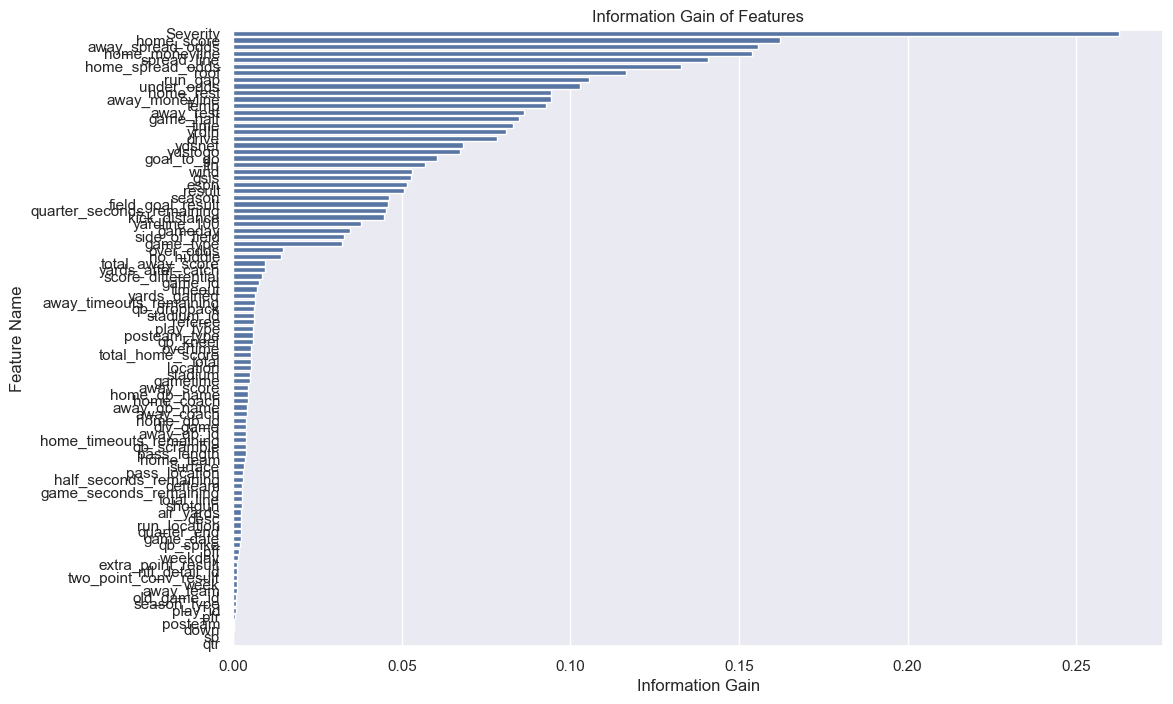

In [24]:
# Visualize the information gain of each feature
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(12,8)})
sns.barplot(x=list(ig_dict_sorted.values()), y=list(ig_dict_sorted.keys()))
plt.title('Information Gain of Features')
plt.xlabel('Information Gain')
plt.ylabel('Feature Name')
plt.show()